In [4]:
### RUN THIS CELL ASAP!

from keras.applications.resnet50 import ResNet50
base_model = ResNet50(include_top=False, weights='imagenet')

# It will download something we will need later
# (it takes a while)

Using TensorFlow backend.


# Convolutional Neural networks 101

> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
</span>


Convolutional neural networks (or ConvNets) are a very succesfull type of neural networks, and are an integral part of reigniting the interest in neural networks.
They are abel to extract structural relations in the data such as spatial in images or temporal in time series.

Jason Yosinski and colleague developed a [toolbox for visualizing convolutional networks](http://yosinski.com/deepvis).
Unfortunately this toolbox is for *Caffe*, so we can't use it here, but they made a [VERY instructive video](https://www.youtube.com/watch?v=AgkfIQ4IGaM) that does a great job of conveying the intuitions.

In this lab you will learn what *convolutional layers* are and how they work, as well as important related concepts such as *padding*, *stride*, and *pooling*.



#### External resources:
For an indept tutorial please see [stanford cs231n](http://cs231n.github.io/convolutional-networks/) or to read more see [Michael Nielsen](http://neuralnetworksanddeeplearning.com/chap6.html).


## What are convolutional networks?

ConvNets are in may respects very similar to the dense feedforward networks we saw previously:
 * The network is still organized into layers
 * Each layer is parameterized by weights and biases
 * Each layer has an element-wise non-linear transformation (activation function)
 * There are no cycles in the connections (more on this in later labs)

*So what is the difference?*
The networks we saw previously are called *dense* because each unit receives input from all the units in the previous layer.
This is not the case for ConvNets.
In ConvNets each unit is only connected to a small subset of the input units.
This is called the *receptive field* of the unit.

#### Let us look at a quick example.
Let us define a `3x3` window with the kernel weights (indicated by red in the bottom right).
We apply the window by performning elementwise multiplication, and then summing the results, as shown in this animation:

<img src="images/convolutions.gif" style="width: 400px;"/> 
[GIF courtesy of [Stanford](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution)]

After having convolved the image we perform an elementwise non-linear transformation on the *convolved features*.
In this example the input is a 2D *feature map* with depth 1.


### Strides, padding, and pooling

Two important concepts for ConvNets are *strides* and *padding*.
#### Padding
describes what we do at the edges of the feature map.
If we don't use padding the feature map will get smaller every time, as we can see above. 
If we do use padding we can maintain the same resolution. 
In deep learning we generally just pad with zeros.
In the example below in the '_Padding, no strides_' GIF we maintain the size by padding with one row/column of zeros on all sides.


#### Strides
describe how far the window is moved each time. Strides can be used to reduce the size of the feature map, and the number of computations that needs to be performed.

Strides and pooling (exerpted from [here](https://github.com/vdumoulin/conv_arithmetic#convolution-animations)) are shown in the table below.
Notice how the output (green) changes shape.

| ![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif) | ![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/same_padding_no_strides.gif) | ![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_strides.gif) | ![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides.gif) |
|--------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| No padding, no strides                                                                     | Padding, no strides                                                                          | No padding, stride of 2                                                                 | Padding, stride of 2                                                                 |


#### Pooling
is another method for reducing the spatial resolution. Similar to convolutional layers it works by sliding a window accross the feature map. Unlike the convolutional layers there are no learnable parameters, and the pooling layers perform the same simple operation every time. The most common types of pooling are:
 * *Max pooling* where the output of the pooling operation is the highest value in the window, and
 * *Mean pooling* which outputs the mean of the elements in the window.
 
![Max pooling image](images/maxpooling.png)
[Image courtesy of [Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)]


# Optional: A few pointers for image classification
If you want do image classification using a pretrained model is often a good choice.
It can greatly reduce training time, and help if you have limited amounts of labeled data.

There are several popular choices, such as Google Inception model, VGG16, VGG19 and ResNet to name a few.
Keras provides several of these models as [nicely packaged ready-to-go models](https://keras.io/applications).
And TensorFlow has a guide for using their current state-of-the-art pretrained model in their [model repository](https://github.com/tensorflow/models/tree/master/inception).
Torch and Theano have similar pretrained models that you can find with google. 


## Visualizing the filters

In the following we will load **ResNet** model, and visualize the kinds of transformations that it sees.
This is both useful for giving you an intuition about what is happening, and showing you how pre-trained models can be loaded.


Convolution filters can be interpreted as spatial feature detectors picking up different image features such as edges, corners etc.
Below we provide code for visualization of the filters.

### ResNet

ResNet was very sucessful when it first came out, having the worlds best performance for a while, and still forming the foundation for many of the state-of-the-art networks that are being proposed currently.
See the original paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) for more details, or this interesting [blog post](http://torch.ch/blog/2016/02/04/resnets.html). 



In [5]:
%matplotlib inline
from scipy import misc
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import numpy as np

import tensorflow as tf

# Collect all the variables and names in a dict
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    names_and_vars = {var.name: sess.run(var.value()) for var in tf.global_variables()}

In [6]:
### If you ware interested you can uncomment this line and see the architecture details
base_model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 64 0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [7]:
### This code was used to find the name of the weights
# names = [key for key in names_and_vars.keys()]
# names.sort()
# for n in names:
#     if n.endswith('kernel:0') and \
#             n.startswith(''):

#         np_W = names_and_vars[n] # get the filter values from the first conv layer
#         print(n, '  \t', np_W.shape)

weight_to_vis = 'conv1/kernel:0'


(7, 7, 3, 64) i.e. the shape is filter_size, filter_size, num_channels, num_filters
img size (253, 337)


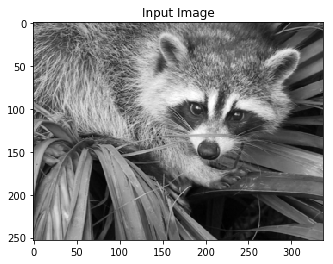

learned filter values


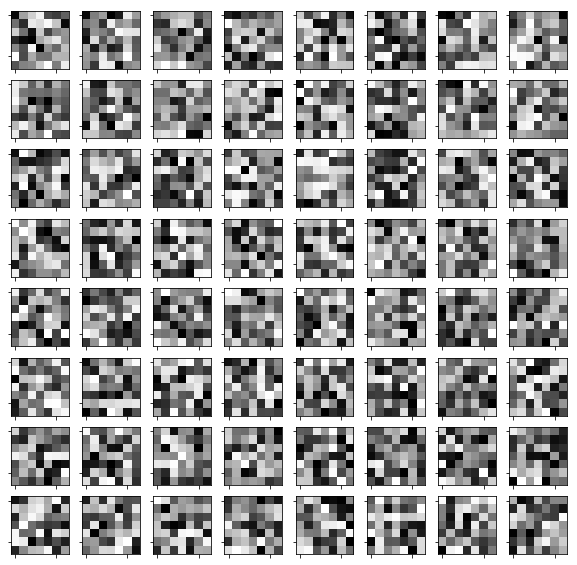

Response from input image convolved with the filters


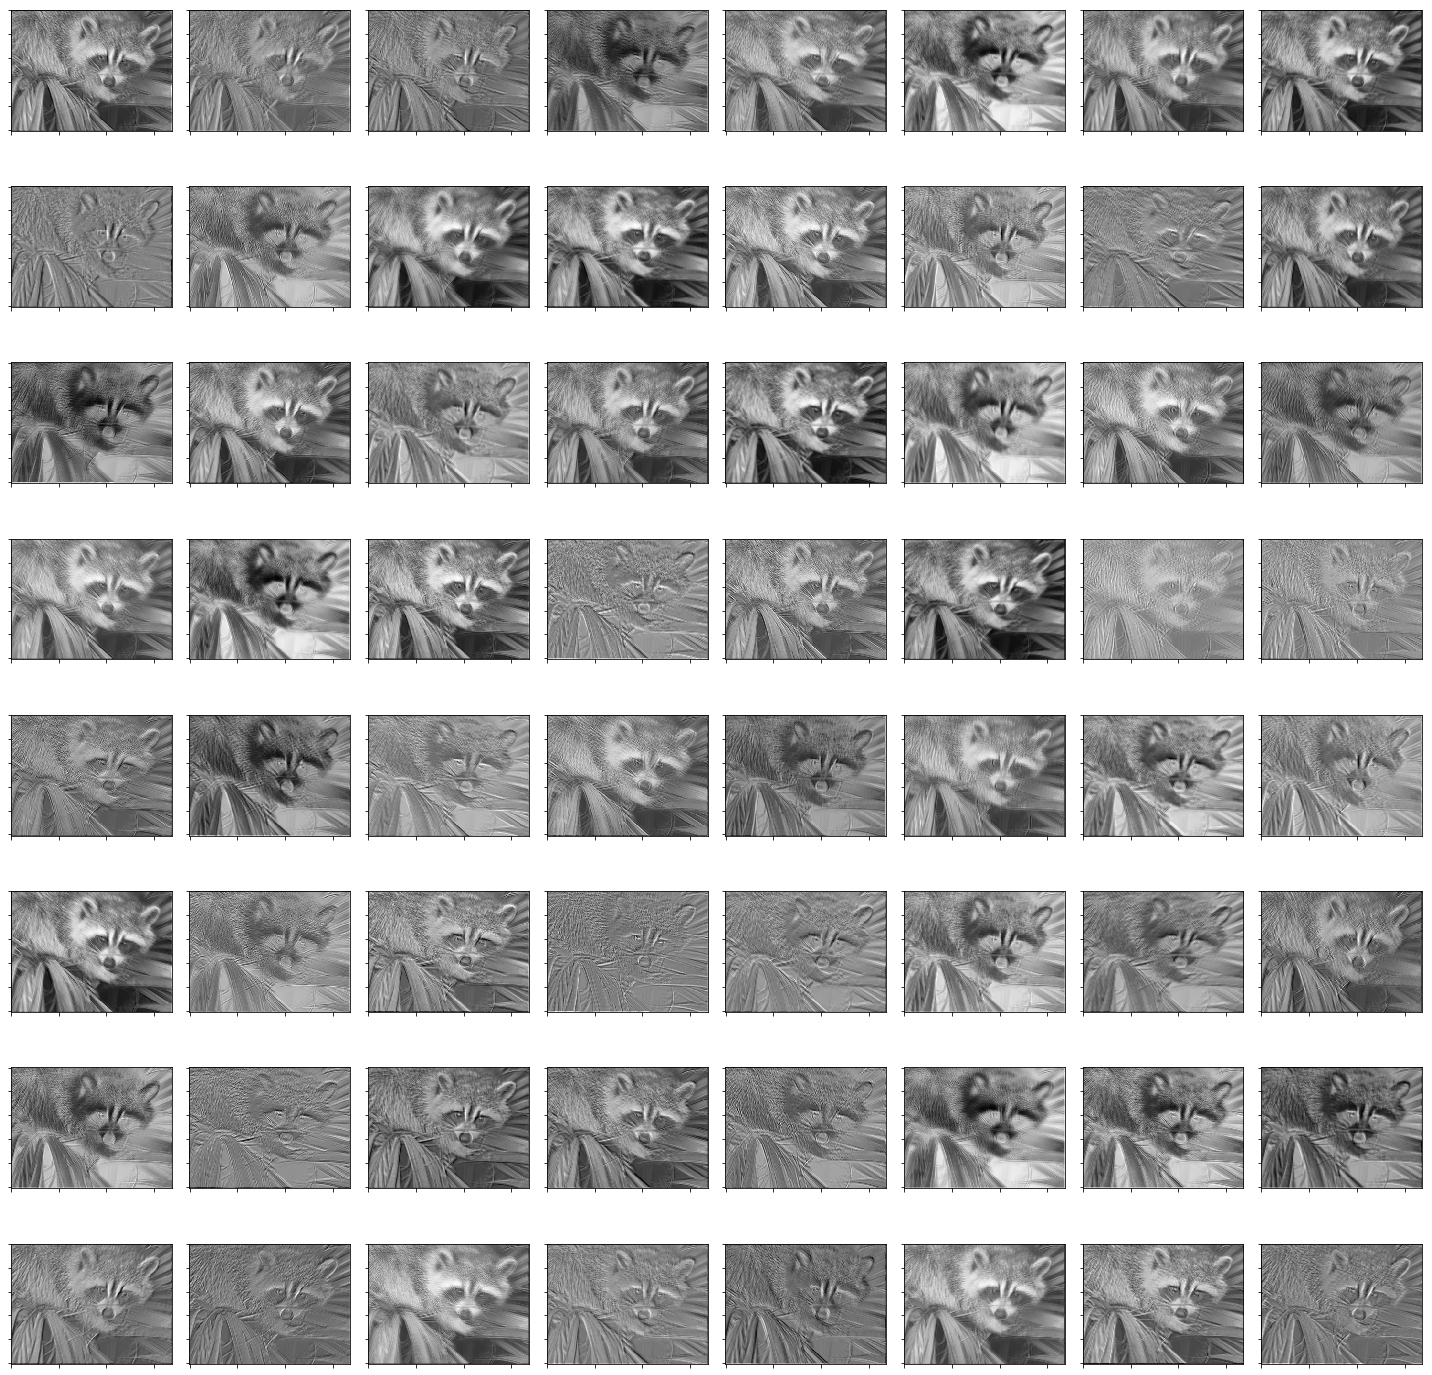

Done!


In [8]:
## Visualize the weights
if not weight_to_vis in names_and_vars:
    print("ERROR: The name provided wasn't found.")

else:
    np_W = names_and_vars[weight_to_vis] # get the filter values from the first conv layer
    print(np_W.shape, "i.e. the shape is filter_size, filter_size, num_channels, num_filters")
    filter_size, _, num_channels, num_filters = np_W.shape
    n = int(num_filters**0.5)

    idx = 1
    plt.figure()
    img = np.mean(misc.face(), axis=2)
    img = misc.imresize(img, 0.33)
    print('img size', img.shape)
    plt.imshow(img,cmap='gray',interpolation='none')
    plt.title('Input Image')
    plt.show()
    
    # reshaping the last dimension to be n by n
    np_W_res = np_W.reshape(filter_size, filter_size, num_channels, n, n)
    fig, ax = plt.subplots(n,n,figsize=(10,10))
    print("learned filter values")
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(np_W_res[:,:,0,i,j], cmap='gray',interpolation='none')
            ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
            ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())
    plt.show()

    
    #visalize the filters convolved with an input image
    np_W_res = np_W.reshape(filter_size, filter_size, num_channels, n, n)
    fig, ax = plt.subplots(n,n,figsize=(20,20))

    print("Response from input image convolved with the filters")
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(convolve2d(img, np_W_res[:,:,0,i,j], mode='same'),
                           cmap='gray', interpolation='none')
            ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
            ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())
    plt.tight_layout()
    plt.show()

print("Done!")



If you didn't already, you really should [watch this video](https://www.youtube.com/watch?v=AgkfIQ4IGaM)